In [1]:
import numpy as np

In [3]:
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')


RuntimeError: Visible devices cannot be modified after being initialized

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# ---------------------------
# Aggregation Layer
# ---------------------------
class AggregationLayer(layers.Layer):
    """
    Aggregates features over the sequence dimension.
    Supported aggregations: "mean" or "max".
    """
    def __init__(self, aggreg="mean", **kwargs):
        super(AggregationLayer, self).__init__(**kwargs)
        self.aggreg = aggreg

    def call(self, inputs):
        if self.aggreg == "mean":
            return tf.reduce_mean(inputs, axis=1)
        elif self.aggreg == "max":
            return tf.reduce_max(inputs, axis=1)
        else:
            raise ValueError("Aggregation not implemented. Use 'mean' or 'max'.")

# ---------------------------
# Fixed Compression Multi-Head Attention
# ---------------------------
class FixedCompressionMultiHeadAttention(layers.Layer):
    def __init__(self, d_model, num_heads, fixed_compression=None, **kwargs):
        """
        A multi-head attention layer that uses a fixed key/value compression.
        
        Instead of learning a projection matrix to compress the sequence,
        this layer uses a fixed tensor of shape (num_heads, 5, depth)
        (computed from the first particle of the first 5 jets) for both keys and values.
        
        Args:
          d_model: Dimensionality of the model.
          num_heads: Number of attention heads.
          fixed_compression: A constant tensor of shape (num_heads, 5, depth)
                             to be used as the compressed keys and values.
        """
        super(FixedCompressionMultiHeadAttention, self).__init__(**kwargs)
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.depth = d_model // num_heads  # dimension per head
        self.fixed_compression = fixed_compression  # expected shape: (num_heads, 5, self.depth)

    def build(self, input_shape):
        # input_shape: (batch_size, seq_len, d_model)
        # Standard dense matrices for Q, K, and V.
        self.wq = self.add_weight(shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name="wq")
        self.wk = self.add_weight(shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name="wk")
        self.wv = self.add_weight(shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name="wv")
        self.dense = layers.Dense(self.d_model)
        super(FixedCompressionMultiHeadAttention, self).build(input_shape)

    def split_heads(self, x, batch_size):
        # x shape: (batch_size, seq_len, d_model)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        # Transpose to shape: (batch_size, num_heads, seq_len, depth)
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, x):
        batch_size = tf.shape(x)[0]
        # Compute linear projections.
        q = tf.matmul(x, self.wq)  # (batch_size, seq_len, d_model)
        k = tf.matmul(x, self.wk)
        v = tf.matmul(x, self.wv)

        # Split into heads.
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len, depth)
        # Although we compute k and v from the input, we replace their projection.
        # Instead, we use the fixed compression tensor for both keys and values.
        if self.fixed_compression is None:
            raise ValueError("fixed_compression tensor has not been set.")
        k_proj = self.fixed_compression  # shape: (num_heads, 5, depth)
        v_proj = self.fixed_compression  # shape: (num_heads, 5, depth)

        # Scaled dot-product attention.
        dk = tf.cast(self.depth, tf.float32)
        # q: (batch_size, num_heads, seq_len, depth)
        # k_proj: (num_heads, 5, depth) -> expand to (batch_size, num_heads, 5, depth)
        # We can add a batch dimension via broadcasting.
        scores = tf.matmul(q, k_proj, transpose_b=True) / tf.math.sqrt(dk)
        # scores shape: (batch_size, num_heads, seq_len, 5)
        attn_weights = tf.nn.softmax(scores, axis=-1)
        attn_output = tf.matmul(attn_weights, v_proj)  # shape: (batch_size, num_heads, seq_len, depth)

        # Concatenate heads.
        attn_output = tf.transpose(attn_output, perm=[0, 2, 1, 3])
        concat_output = tf.reshape(attn_output, (batch_size, -1, self.d_model))
        output = self.dense(concat_output)
        return output

# ---------------------------
# Transformer Block using Fixed Compression Attention
# ---------------------------
class FixedCompressionTransformerBlock(layers.Layer):
    def __init__(self, d_model, d_ff, output_dim, num_heads, fixed_compression=None, **kwargs):
        super(FixedCompressionTransformerBlock, self).__init__(**kwargs)
        self.attention = FixedCompressionMultiHeadAttention(d_model, num_heads, fixed_compression)
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn = tf.keras.Sequential([
            layers.Dense(d_ff, activation='relu'),
            layers.Dense(d_model)
        ])
        self.outD = layers.Dense(output_dim)

    def call(self, x):
        attn_output = self.attention(x)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(x + ffn_output)
        return out2

# ---------------------------
# Transformer Classifier Model
# ---------------------------
def build_transformer_classifier(num_particles, feature_dim,
                                 d_model=16, d_ff=16, output_dim=16,
                                 num_heads=8, fixed_compression=None):
    """
    Builds a classifier with:
      - A linear embedding layer.
      - A transformer block using fixed compression attention.
      - Aggregation over the sequence dimension.
      - A final output layer for 5 classes.
    """
    inputs = layers.Input(shape=(num_particles, feature_dim))
    x = layers.Dense(d_model, activation='relu')(inputs)
    x = FixedCompressionTransformerBlock(d_model, d_ff, output_dim, num_heads, fixed_compression)(x)
    pooled_output = AggregationLayer(aggreg='max')(x)
    x = layers.Dense(d_model, activation='relu')(pooled_output)
    outputs = layers.Dense(5, activation='softmax')(x)
    return Model(inputs=inputs, outputs=outputs)

# ---------------------------
# Example Training Setup and Fixed Compression Computation
# ---------------------------
import numpy as np
from sklearn.model_selection import train_test_split

# Load your data.
x_train = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/x_train_robust_32const_ptetaphi.npy")
y_train = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/y_train_robust_32const_ptetaphi.npy")

# Split into training and validation sets.
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, shuffle=True
)

# Determine input dimensions.
num_particles = x_train.shape[1]
feature_dim = x_train.shape[-1]

# --- Compute the Fixed Compression Tensor ---
# For the first 5 jets in the training set, extract the first particle.
# x_train has shape (num_samples, num_particles, feature_dim)
first_particles = x_train[:5, 0, :]  # shape: (5, feature_dim)

# We need to embed these to match the per-head depth.
# For our example: d_model=16 and num_heads=8, so depth = 16/8 = 2.
# Create an embedding layer that maps from feature_dim to 2.
embed_layer = tf.keras.layers.Dense(2, activation=None)
embedded = embed_layer(first_particles)  # shape: (5, 2)

# Now, replicate this for each head. We want a tensor of shape (num_heads, 5, 2).
num_heads = 8
fixed_compression = tf.stack([embedded for _ in range(num_heads)], axis=0)
# fixed_compression now has shape (8, 5, 2) and will remain constant.

# --- Build the Model ---
model = build_transformer_classifier(num_particles, feature_dim,
                                     d_model=16, d_ff=16, output_dim=16,
                                     num_heads=num_heads,
                                     fixed_compression=fixed_compression)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


/Users/anrunw/miniconda3/envs/tf_env/lib/python3.12/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'fixed_compression_transformer_block_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fixed_compression_transformer_… │ (None, 32, 16)         │         1,648 │
│ (FixedCompressionTransformerBl… │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aggregation_layer_2             │ (None, 16)             │             0 │
│ (AggregationLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,069 (8.08 KB)

 Trainable params: 2,069 (8.08 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from sklearn.model_selection import train_test_split


In [8]:
x_train = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/x_train_robust_32const_ptetaphi.npy")
y_train = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/y_train_robust_32const_ptetaphi.npy")

# Perform an 80/20 split on the original training data
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, shuffle=True
)


In [9]:
#model.load_weights('1layerLinformerCompress1.weights.h5')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()





Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fixed_compression_transformer_… │ (None, 32, 16)         │         1,648 │
│ (FixedCompressionTransformerBl… │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aggregation_layer_2             │ (None, 16)             │             0 │
│ (AggregationLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,069 (8.08 KB)

 Trainable params: 2,069 (8.08 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=500, 
    batch_size=1024)

Epoch 1/500


/Users/anrunw/miniconda3/envs/tf_env/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['fixed_compression_transformer_block_2/fixed_compression_multi_head_attention_2/wk', 'fixed_compression_transformer_block_2/fixed_compression_multi_head_attention_2/wv'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
2025-04-02 16:53:00.753561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-04-02 16:53:00.761716: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


485/485 ━━━━━━━━━━━━━━━━━━━━ 26s 38ms/step - accuracy: 0.3676 - loss: 1.4689 - val_accuracy: 0.5514 - val_loss: 1.1187
Epoch 2/500
485/485 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.5717 - loss: 1.0874 - val_accuracy: 0.6073 - val_loss: 1.0381
Epoch 3/500
485/485 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.6129 - loss: 1.0245 - val_accuracy: 0.6210 - val_loss: 0.9991
Epoch 4/500
485/485 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.6307 - loss: 0.9828 - val_accuracy: 0.6583 - val_loss: 0.9353
Epoch 5/500
485/485 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - accuracy: 0.6591 - loss: 0.9278 - val_accuracy: 0.6705 - val_loss: 0.9094
Epoch 6/500
485/485 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - accuracy: 0.6688 - loss: 0.9062 - val_accuracy: 0.6733 - val_loss: 0.8961
Epoch 7/500
485/485 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.6743 - loss: 0.8922 - val_accuracy: 0.6765 - val_loss: 0.8885
Epoch 8/500
485/485 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.6775 - loss: 0.8862 - val_

In [ ]:
model.save_weights('1layerLinformerCompressOne32part.weights.h5')

In [ ]:
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph
import time
import numpy as np

def get_flops(model, input_shape):
    # Create a concrete function from the Keras model.
    input_tensor = tf.TensorSpec(input_shape, tf.float32)
    concrete_func = tf.function(model).get_concrete_function(input_tensor)
    
    # Convert the model to a frozen graph.
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func)
    
    # Import the graph_def into a new graph.
    with tf.Graph().as_default() as graph:
        tf.compat.v1.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd='op', options=opts)
        return flops.total_float_ops

# Assuming x_val is already loaded and has shape (num_samples, features, ...)
# For a single event, we use a batch size of 1.
input_shape = [1] + list(x_val.shape[1:])
total_flops = get_flops(model, input_shape)
print("Total FLOPs for a single inference:", total_flops)

# ---------------------------
# Time Inference Per Event
# ---------------------------
# Warm-up: Run one inference to load any lazy initializations.
import numpy as np
import time

# Warm-up (optional but recommended)
_ = model(x_val[:10000])

num_trials = 100
inference_times = []
for _ in range(num_trials):
    start_time = time.perf_counter()
    _ = model(x_val[:10000])
    end_time = time.perf_counter()
    inference_times.append(end_time - start_time)

# Compute average inference time per event in seconds, then convert to nanoseconds
avg_inference_time_seconds = np.mean(np.array(inference_times) / 10000)
avg_inference_time_nanoseconds = avg_inference_time_seconds * 1e9

print("Average inference time per event:", np.round(avg_inference_time_nanoseconds,3), "nanoseconds")



Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


2025-03-27 00:28:10.082160: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2025-03-27 00:28:10.082222: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-03-27 00:28:10.082379: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-27 00:28:10.082392: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Total FLOPs for a single inference: 128974

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. 

In [17]:
x_val = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/x_val_robust_32const_ptetaphi.npy")
y_val = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/y_val_robust_32const_ptetaphi.npy")

In [18]:
xout = np.argmax(model(x_val, training=False),1)
yout = np.argmax(y_val,1)

In [19]:
import sklearn
sklearn.metrics.accuracy_score(xout,yout)

0.7740807692307692

In [25]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 16, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 16, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ linformer_transformer_block_2   │ (None, 16, 16)         │         2,160 │
│ (LinformerTransformerBlock)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aggregation_layer_2             │ (None, 16)             │             0 │
│ (AggregationLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,745 (30.26 KB)

 Trainable params: 2,581 (10.08 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,164 (20.18 KB)

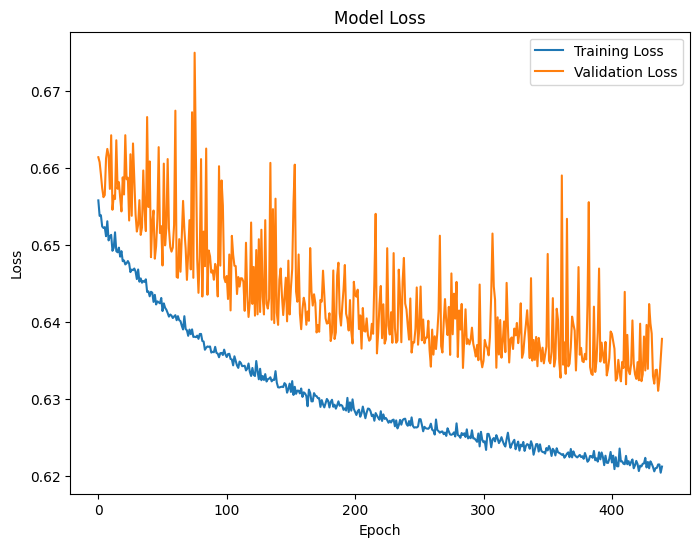

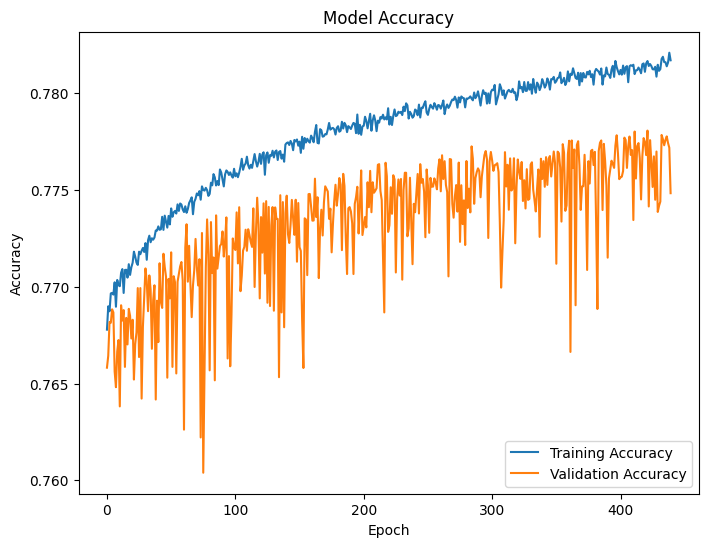

In [20]:
import matplotlib.pyplot as plt

# Suppose you have already trained your model:
# history = model.fit(...)

# Plotting the training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# If you also have accuracy or other metrics, you can plot them similarly:
if 'accuracy' in history.history:
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()


1/FPR at TPR=80% for each class:
g: 1/FPR = 9.14963198025475
q: 1/FPR = 8.115104570100696
W: 1/FPR = 24.82554666029394
Z: 1/FPR = 27.77135980746089
t: 1/FPR = 24.937477455813394
Average 1/FPR across classes: 18.959824094784732

Accuracy at the threshold corresponding to TPR=80% for each class:
g: accuracy = 0.8724
q: accuracy = 0.8619
W: accuracy = 0.9276
Z: accuracy = 0.9310
t: accuracy = 0.9276
Average accuracy across classes: 0.9041


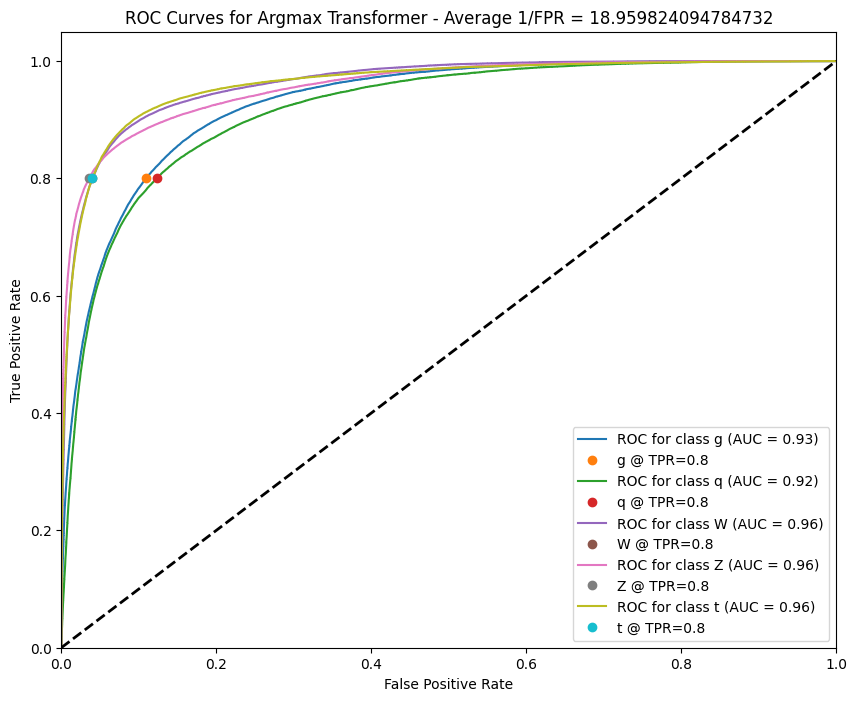

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import tensorflow as tf

# Define your class labels.
class_labels = ['g', 'q', 'W', 'Z', 't']

# Load your validation data.
# (Assuming x_val and y_val are already loaded in your environment)
# Get the model predictions as probabilities.
# If your model outputs logits, you may need to apply softmax first.
y_pred = model(x_val, training=False)

# Convert predictions and labels from TensorFlow tensors to NumPy arrays if needed.
if hasattr(y_pred, "numpy"):
    y_pred = y_pred.numpy()
if hasattr(y_val, "numpy"):
    y_val = y_val.numpy()

# Initialize dictionaries to store false positive rates, true positive rates, AUC, thresholds,
# interpolated FPR at target TPR, and accuracy at that threshold.
fpr = {}
tpr = {}
roc_auc = {}
thresholds_dict = {}
fpr_at_target = {}
accuracy_at_target = {}

# Target true positive rate.
target_tpr = 0.8

# Compute ROC curve, AUC, and interpolate FPR and threshold at target TPR for each class.
for i, label in enumerate(class_labels):
    # Compute ROC curve: returns fpr, tpr, and thresholds.
    fpr[i], tpr[i], thresholds = roc_curve(y_val[:, i], y_pred[:, i])
    thresholds_dict[i] = thresholds  # save thresholds for later use
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Check if the target TPR is reached.
    if target_tpr <= tpr[i][-1]:
        # Interpolate FPR at target TPR.
        fpr_at_target[label] = np.interp(target_tpr, tpr[i], fpr[i])
        # Interpolate threshold at target TPR.
        threshold_at_target = np.interp(target_tpr, tpr[i], thresholds)
        # Compute binary predictions for the current class using the interpolated threshold.
        preds_binary = (y_pred[:, i] >= threshold_at_target).astype(int)
        # Compute accuracy for the current class.
        accuracy = np.mean(preds_binary == y_val[:, i])
        accuracy_at_target[label] = accuracy
    else:
        fpr_at_target[label] = None  # If target TPR is not reached.
        accuracy_at_target[label] = None

# Display the 1/FPR values when TPR=80% for each class.
print("1/FPR at TPR=80% for each class:")
one_over_fpr = []
for label in class_labels:
    if fpr_at_target[label] is not None and fpr_at_target[label] != 0:
        inv_val = 1.0 / fpr_at_target[label]
        one_over_fpr.append(inv_val)
        print(f"{label}: 1/FPR = {inv_val}")
    else:
        print(f"{label}: undefined (FPR is None or zero)")

# Compute and print the average of 1/FPR across classes.
if one_over_fpr:
    avg_one_over_fpr = np.mean(one_over_fpr)
    print(f"Average 1/FPR across classes: {avg_one_over_fpr}")
else:
    print("No valid 1/FPR values to compute an average.")

# Print the accuracy at the FPR corresponding to TPR=80% for each class.
print("\nAccuracy at the threshold corresponding to TPR=80% for each class:")
accuracies = []
for label in class_labels:
    if accuracy_at_target[label] is not None:
        accuracies.append(accuracy_at_target[label])
        print(f"{label}: accuracy = {accuracy_at_target[label]:.4f}")
    else:
        print(f"{label}: accuracy undefined (target TPR not reached)")
if accuracies:
    avg_accuracy = np.mean(accuracies)
    print(f"Average accuracy across classes: {avg_accuracy:.4f}")
else:
    print("No valid accuracy values to compute an average.")

# Plot the ROC curves and mark the point corresponding to TPR=0.8.
plt.figure(figsize=(10, 8))
for i, label in enumerate(class_labels):
    plt.plot(fpr[i], tpr[i], label=f'ROC for class {label} (AUC = {roc_auc[i]:.2f})')
    if fpr_at_target[label] is not None:
        # Mark the point on the ROC curve where TPR = 0.8.
        plt.plot(fpr_at_target[label], target_tpr, 'o', label=f'{label} @ TPR=0.8')

# Plot the random chance line.
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Argmax Transformer - Average 1/FPR = ' + str(avg_one_over_fpr))
plt.legend(loc="lower right")
plt.show()



In [52]:
# Build the model with proj_dim = 1.
model = build_linformer_transformer_classifier(num_particles, feature_dim,
                                               d_model=16, d_ff=16, output_dim=16,
                                               num_heads=8, proj_dim=1)

# Compile the model (as before).
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Load the saved weights.
model.load_weights('1layerLinformerCompress1.weights.h5')

# Optionally, view the model summary.
model.summary()


/Users/anrunw/miniconda3/envs/tf_env/lib/python3.12/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'linformer_transformer_block_6', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/anrunw/miniconda3/envs/tf_env/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 44 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 16, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 16, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ linformer_transformer_block_6   │ (None, 16, 16)         │         1,904 │
│ (LinformerTransformerBlock)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aggregation_layer_6             │ (None, 16)             │             0 │
│ (AggregationLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,325 (9.08 KB)

 Trainable params: 2,325 (9.08 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
class LinformerMultiHeadAttention(layers.Layer):
    def __init__(self, d_model, num_heads, proj_dim, **kwargs):
        super(LinformerMultiHeadAttention, self).__init__(**kwargs)
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.depth = d_model // num_heads
        self.proj_dim = proj_dim
        # This will hold the attention weights from the last forward pass.
        self.last_attention_weights = None

    def build(self, input_shape):
        self.seq_len = input_shape[1]
        self.wq = self.add_weight(shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name="wq")
        self.wk = self.add_weight(shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name="wk")
        self.wv = self.add_weight(shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name="wv")
        self.dense = layers.Dense(self.d_model)
        self.E = self.add_weight(shape=(self.num_heads, self.seq_len, self.proj_dim),
                                 initializer='glorot_uniform',
                                 trainable=True,
                                 name="proj_E")
        self.F = self.add_weight(shape=(self.num_heads, self.seq_len, self.proj_dim),
                                 initializer='glorot_uniform',
                                 trainable=True,
                                 name="proj_F")
        super(LinformerMultiHeadAttention, self).build(input_shape)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, x):
        batch_size = tf.shape(x)[0]
        q = tf.matmul(x, self.wq)
        k = tf.matmul(x, self.wk)
        v = tf.matmul(x, self.wv)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        k_proj = tf.einsum('bhnd, hnr -> bhrd', k, self.E)
        v_proj = tf.einsum('bhnd, hnr -> bhrd', v, self.F)
        dk = tf.cast(self.depth, tf.float32)
        scores = tf.matmul(q, k_proj, transpose_b=True) / tf.math.sqrt(dk)
        attn_weights = tf.nn.softmax(scores, axis=-1)
        # Save the attention weights so they can be inspected later.
        self.last_attention_weights = attn_weights
        attn_output = tf.matmul(attn_weights, v_proj)
        attn_output = tf.transpose(attn_output, perm=[0, 2, 1, 3])
        concat_output = tf.reshape(attn_output, (batch_size, -1, self.d_model))
        output = self.dense(concat_output)
        return output


In [12]:
def build_linformer_transformer_classifier(num_particles, feature_dim,
                                             d_model=16, d_ff=16, output_dim=16,
                                             num_heads=8, proj_dim=8):
    inputs = layers.Input(shape=(num_particles, feature_dim))
    
    x = layers.Dense(d_model, activation='relu')(inputs)
    
    # Name the block for easy access later.
    x = LinformerTransformerBlock(d_model, d_ff, output_dim, num_heads, proj_dim, name="transformer_block")(x)    
    
    pooled_output = AggregationLayer(aggreg='max')(x)
    
    x = layers.Dense(d_model, activation='relu')(pooled_output)
    outputs = layers.Dense(5, activation='softmax')(x)
    
    return Model(inputs=inputs, outputs=outputs)


In [13]:
# Load data (make sure the file paths are correct)
x_train = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/x_train_robust_16const_ptetaphi.npy")
y_train = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/y_train_robust_16const_ptetaphi.npy")

# Optionally, perform an 80/20 split if needed.
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, shuffle=True
)

num_particles = x_train.shape[1]
feature_dim = x_train.shape[-1]

# Build and compile the model.
model = build_linformer_transformer_classifier(num_particles, feature_dim,
                                               d_model=16, d_ff=16, output_dim=16,
                                               num_heads=8, proj_dim=1)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

# Take only one sample (one row) from the training data.
sample = x_train[:1]  # shape: (1, num_particles, feature_dim)

# Run a forward pass through the model.
_ = model(sample)

# Retrieve the attention weights.
# The transformer block is the third layer in the model (index 2).
# Its attention layer is accessible via its 'attention' attribute.
attention_matrix = model.get_layer("transformer_block").attention.last_attention_weights

# Print the attention matrix.
print("Attention Matrix shape:", attention_matrix.shape)
print("Attention Matrix values:\n", attention_matrix.numpy())


/Users/anrunw/miniconda3/envs/tf_env/lib/python3.12/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'transformer_block', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 16, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 16, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 16, 16)         │         1,904 │
│ (LinformerTransformerBlock)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aggregation_layer_3             │ (None, 16)             │             0 │
│ (AggregationLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,325 (9.08 KB)

 Trainable params: 2,325 (9.08 KB)

 Non-trainable params: 0 (0.00 B)

Attention Matrix shape: (1, 8, 16, 1)
Attention Matrix values:
 [[[[1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
  

In [71]:
np.zeros([16,16,4])[:,:,3]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [149]:
def superpositionMLP(superposition, weight, bias = np.zeros(16)):


    output = np.einsum('bij,ik->bkj', superposition, weight)

    output[:, :,3] += bias

    return output

def superPositionRelu(superposition):
    # Compute the sum of activations along each neuron's dimension.
    total_activations = np.sum(superposition, axis=2)
    
    # Zero out rows (neurons) with non-positive total activations.
    superposition[total_activations < 0] = 0
    return superposition

In [150]:
superposition = np.zeros((16, 3, 4))
num = 0
for x in x_val[0]:
    index = 0
    for feature in range(3):

        superposition[num, index, index] = x[index]

        index = index + 1
    num = num + 1

In [151]:
model.variables[1]

<Variable path=dense_28/bias, shape=(16,), dtype=float32, value=[-0.13730128 -0.17023899 -0.04812371 -0.06350124 -0.09528249 -0.13202193
  0.06482219  0.15857786  0.04920047  0.01534957  0.02712428  0.03955009
 -0.04367823 -0.03985824 -0.05933958 -0.18136433]>

In [152]:
superposition = superpositionMLP(superposition, model.variables[0], model.variables[1])
superposition = superPositionRelu(superposition)

In [153]:
superposition = superpositionMLP(superposition, model.variables[4])

In [160]:
superposition[0]

array([[ 6.78882964e-04,  3.54708613e-03, -1.87849032e-04,
        -2.72385209e-02],
       [-3.35905968e-03, -6.45207313e-03,  4.26786544e-03,
        -1.60015847e-02],
       [-9.08796234e-03, -1.64964727e-02, -2.78944434e-03,
         2.59307059e-02],
       [ 1.58776187e-03, -8.95994160e-05, -5.29249415e-03,
        -3.36708282e-02],
       [-7.04042084e-03,  5.41434104e-03, -3.92332908e-03,
        -1.12827108e-01],
       [-4.10277926e-03,  5.87353215e-03,  9.93852729e-05,
        -7.87967528e-02],
       [ 9.66920972e-04,  8.77597606e-04,  4.91945788e-03,
        -5.70989777e-02],
       [ 3.71548733e-03,  5.68443433e-03, -8.13824820e-04,
        -2.66003815e-02],
       [-4.36769056e-02, -4.09754564e-04,  3.38890568e-03,
        -3.14428142e-02],
       [ 1.75312202e-03,  1.23676898e-02, -1.92321974e-03,
         4.28216496e-02],
       [-2.11287729e-02,  1.40066084e-02,  5.19993333e-04,
         3.54282729e-03],
       [ 2.37767460e-03,  1.27788539e-03,  1.44062871e-03,
      

In [ ]:
import matplotlib.pyplot as plt

for num in range(8):
    plt.figure()
    # Get x values (0 to 127) and y values for the current row
    x = range(16)
    y = model.variables[6][num] 
    
    # Assign colors based on y value: red if below 0, blue if 0 or above
    colors = ['red' if val < 0 else 'blue' for val in y]
    
    # Create scatter plot with color coding
    plt.scatter(x, y, c=colors, s=10)
    plt.ylim(-1,1)
    # Draw a horizontal line at y = 0
    plt.axhline(y=0, color='black', linewidth=1)
    
    plt.show()
